<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to Training Image Classification Models

In this notebook, we will give an introduction to using fast.ai for image classification. We will use a small dataset of four differenet beverages to train and evaluate a model. We'll also cover one of the most common ways to store your data in your file system for image classification modelling.

Check out fastai version.

In [1]:
import fastai
from torch.cuda import get_device_name

print(f"Fast.ai: {fastai.__version__}")
print(get_device_name(0))

Fast.ai: 1.0.48
Tesla K80


Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [3]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils_ic.plot_utils import ICResultsWidget, plot_roc_curve, plot_precision_recall_curve
from utils_ic.datasets import Urls, unzip_url, data_path
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

Set some parameters. We'll use the `unzip_url` helper function to download and unzip our data.

In [4]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## File Structure for Image Classification

In this notebook, we'll use images from the `fridge_objects` dataset, which has been downloaded and unzip to  `image_classification/data`.

Lets set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [5]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/data/home/jumin/git/cvbp/image_classification/data/fridgeObjects/models'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/data/fridgeObjects/carton'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/data/fridgeObjects/can'),
 PosixPath('/data/home/jumin/git/cvbp/image_classification/data/fridgeObjects/milk_bottle')]

You'll notice that we have four different folders inside:
- `/milk_bottle`
- `/carton`
- `/water_bottle`
- `/can`

The most common data format for multiclass image classification is to have a folder titled the label with the images inside:

```
/images
+-- can (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- carton (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

Good thing our data is already structured in that format!

## Loading images with fast.ai

To use fastai, we want to create an ImageDataBunch so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

In [6]:
data = (ImageList.from_folder(path) 
        .split_by_rand_pct(valid_pct=0.2, seed=10) 
        .label_from_folder() 
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

Lets take a look at our data using the databunch we created.

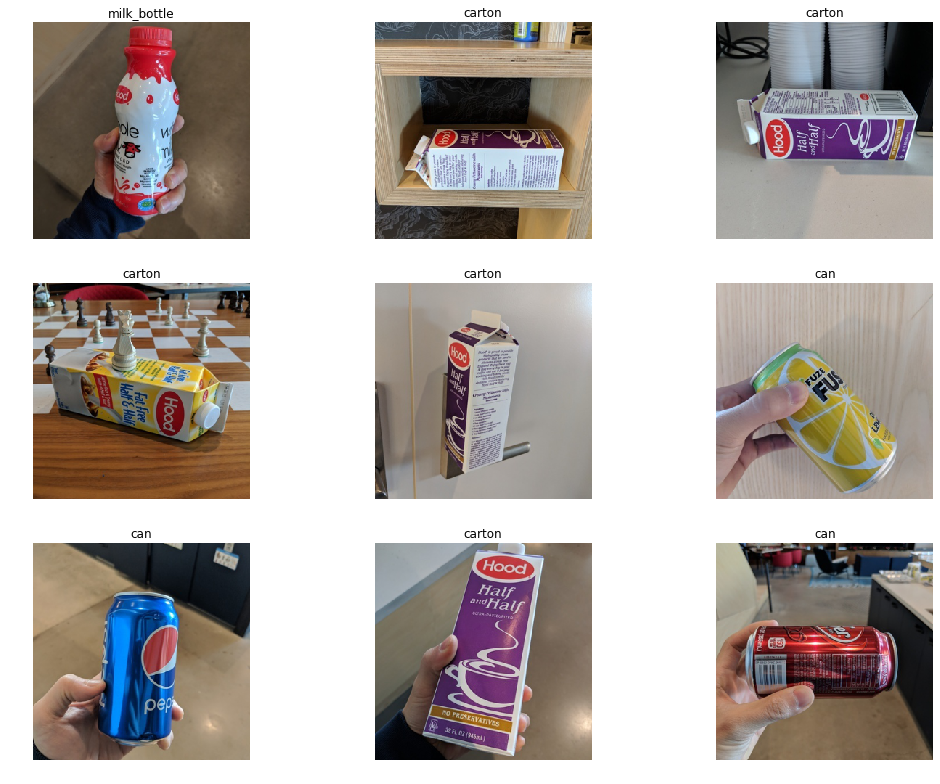

In [7]:
data.show_batch(rows=3, figsize=(15,11))

Lets see all available classes:

In [8]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 3
['can', 'carton', 'milk_bottle']


We can also see how many images we have in our training and validation set.

In [9]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (81 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
carton,carton,carton,carton,carton
Path: /data/home/jumin/git/cvbp/image_classification/data/fridgeObjects;

Valid: LabelList (20 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
milk_bottle,can,milk_bottle,can,can
Path: /data/home/jumin/git/cvbp/image_classification/data/fridgeObjects;

Test: None>

Above, you'll notice that the validation set is 20% of the total images. 

You'll also notice that the test set will be set to `None`. This is because we treat it as a second holdout set that is only used right at the end of a project.

## Training

For the model, we use a concolutional neural network. 

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. 

With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and a performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train imagenet. 

In [10]:
learn = cnn_learner(data, ARCHITECTURE, metrics=accuracy)

Unfreeze our CNN so that we're training all the layers.

In [11]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

In [12]:
learn.fit(EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,accuracy,time
0,0.996024,0.925595,0.600000,00:26
1,0.623865,0.551971,0.900000,00:04
2,0.421814,0.355821,0.900000,00:04
3,0.321685,0.223033,0.950000,00:04
4,0.249809,0.155706,1.000000,00:04


## Evaluating

To evaluate our model, lets take a look at the accuracy on the validation set.

In [13]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {float(metric)}')

Accuracy on validation set: 1.0


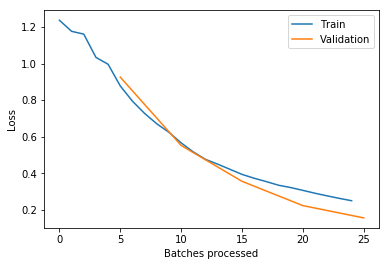

In [14]:
learn.recorder.plot_losses()

Now, let's see precision-recall and ROC curves for each class

In [15]:
# Get prediction scores and target labels of the validation set
pred_scores, pred_trues = [to_np(p) for p in learn.get_preds(ds_type=DatasetType.Valid)]

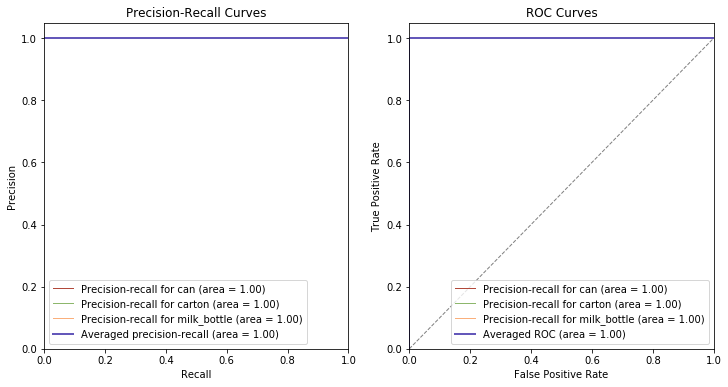

In [16]:
plt.subplots(2, 2, figsize=(12,6))

plt.subplot(1, 2, 1)
plot_precision_recall_curve(pred_trues, pred_scores, data.classes, False)

plt.subplot(1, 2, 2)
plot_roc_curve(pred_trues, pred_scores, data.classes, False)

plt.show()

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

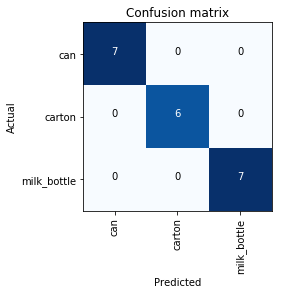

In [19]:
interp.plot_confusion_matrix()

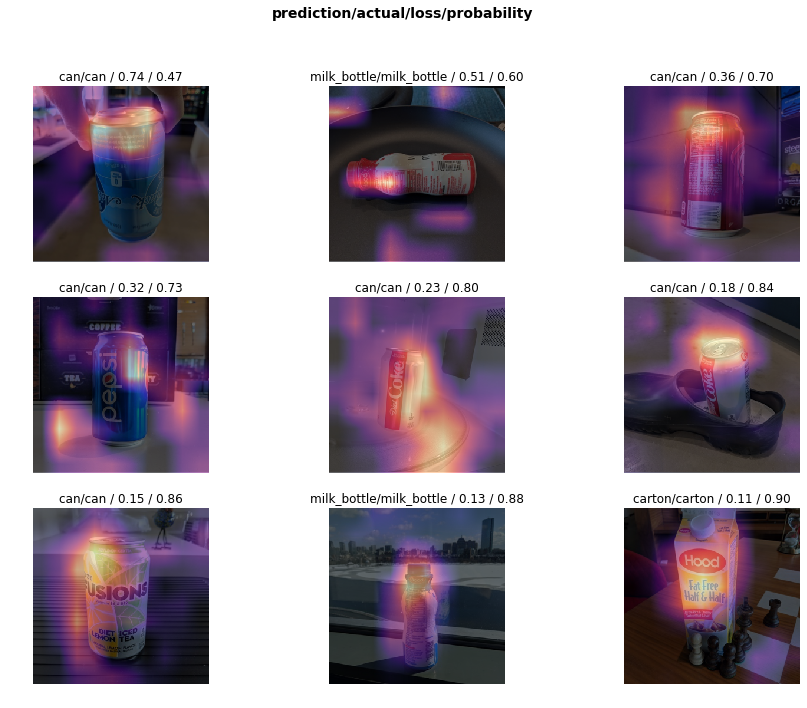

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
results_ui = ICResultsWidget(
    learn.data.valid_ds,
    pred_scores,
    [data.classes[x] for x in np.argmax(pred_scores, axis=1)]
)
display(results_ui.show())